In [1]:
# Cell 1: Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style='whitegrid')


In [2]:
# Cell 2: Load & Inspect Data
df = pd.read_csv('D:\infosysspringboard projects\project1-1stmilestine\AZURE_BACKEND_TEAM-B\data\processed\cleaned_merged.csv', parse_dates=['date'])
print(df.shape, df.columns.tolist())
df.head()


(1080, 9) ['date', 'region', 'resource_type', 'usage_cpu', 'usage_storage', 'users_active', 'economic_index', 'cloud_market_demand', 'holiday']


,date,region,resource_type,usage_cpu,usage_storage,users_active,economic_index,cloud_market_demand,holiday
0,2023-01-01,East US,VM,88,1959,470,104.97,0.99,1
1,2023-01-01,East US,Storage,92,1595,388,104.97,0.99,1
2,2023-01-01,East US,Container,70,621,414,104.97,0.99,1
3,2023-01-01,West US,VM,60,1982,287,104.97,0.99,1
4,2023-01-01,West US,Storage,85,1371,351,104.97,0.99,1


In [3]:
# Cell 3: Aggregate by Region & Date
region_daily = (
    df
    .groupby(['region','date'])
    .agg(usage_cpu=('usage_cpu','mean'),
         usage_storage=('usage_storage','mean'),
         users_active=('users_active','sum'),
         economic_index=('economic_index','first'),
         cloud_market_demand=('cloud_market_demand','first'),
         holiday=('holiday','max'))
    .sort_index()
    .reset_index()
)
print(region_daily.shape)
region_daily.head()


(360, 8)


,region,date,usage_cpu,usage_storage,users_active,economic_index,cloud_market_demand,holiday
0,East US,2023-01-01,83.333333,1391.666667,1272,104.97,0.99,1
1,East US,2023-01-02,91.666667,1456.666667,800,106.48,1.15,0
2,East US,2023-01-03,78.333333,1138.333333,1285,97.66,0.98,0
3,East US,2023-01-04,75.000000,881.000000,872,115.79,1.08,0
4,East US,2023-01-05,86.666667,1234.000000,1017,95.31,1.05,0


In [4]:
# Cell 4: Create Region-Specific Time Series
region_dfs = {}
for region, grp in region_daily.groupby('region'):
    ts = grp.set_index('date').drop('region',axis=1).asfreq('D')
    region_dfs[region] = ts
    print(region, ts.shape)


East US (90, 6)
North Europe (90, 6)
Southeast Asia (90, 6)
West US (90, 6)


In [5]:
# Cell 5: Train/Test Split Function
def train_test_split_ts(ts, train_frac=0.9):
    n = len(ts)
    split = int(train_frac * n)
    return ts.iloc[:split], ts.iloc[split:]


In [6]:
# Cell 6 (updated): ARIMA for each region
from statsmodels.tsa.arima.model import ARIMA

arima_results = {}
def compute_metrics(true_vals, preds):
    rmse = np.sqrt(mean_squared_error(true_vals, preds))
    mae = mean_absolute_error(true_vals, preds)
    mape = np.mean(np.abs((true_vals - preds) / true_vals)) * 100
    return rmse, mae, mape

for region, ts in region_dfs.items():
    split = int(0.8 * len(ts))
    
    if region == 'East US':
        # First differencing to remove trend, per reference
        ts_diff = ts['usage_cpu'].diff().dropna()
        train_ts = ts_diff.iloc[: split - 1]
        test_ts  = ts_diff.iloc[split - 1 :]
        
        # Fit ARIMA on differenced series
        model = ARIMA(train_ts, order=(5, 0, 0)).fit()
        preds_diff = model.forecast(steps=len(test_ts))
        
        # Reconstruct level forecast
        last_train = ts['usage_cpu'].iloc[split - 1]
        arima_preds = np.r_[ [last_train], preds_diff ].cumsum()[1:]
        actual = ts['usage_cpu'].iloc[split:]
        
    else:
        # Standard ARIMA on original series
        train_ts = ts['usage_cpu'].iloc[:split]
        test_ts  = ts['usage_cpu'].iloc[split:]
        
        model = ARIMA(train_ts, order=(5, 1, 0)).fit()
        arima_preds = model.forecast(steps=len(test_ts))
        actual = test_ts.values
    
    # Compute metrics
    arima_rmse, arima_mae, arima_mape = compute_metrics(actual, arima_preds)
    arima_results[region] = (model, arima_rmse, arima_mae, arima_mape)
    
    print(f"{region} ARIMA → RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.1f}%")


East US ARIMA → RMSE: 10.20, MAE: 8.19, MAPE: 11.0%
North Europe ARIMA → RMSE: 8.02, MAE: 6.04, MAPE: 8.3%
Southeast Asia ARIMA → RMSE: 7.46, MAE: 5.99, MAPE: 8.7%
West US ARIMA → RMSE: 16.38, MAE: 14.82, MAPE: 20.9%


In [ ]:
# Cell 7: XGBoost with Rich Features
xgb_results = {}
for region, ts in region_dfs.items():
    df2 = ts.copy()
    # rolling stats + time features
    df2['lag1'] = df2['usage_cpu'].shift(1)
    df2['lag7'] = df2['usage_cpu'].shift(7)
    df2['roll7_mean'] = df2['usage_cpu'].rolling(7).mean()
    df2['dow'] = df2.index.dayofweek
    df2.dropna(inplace=True)
    features = ['lag1','lag7','roll7_mean','users_active','economic_index','dow','holiday']
    X, y = df2[features], df2['usage_cpu']
    split = int(0.8*len(X))
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=800,learning_rate=0.1,
    max_depth=5,
    random_state=42)

   

    model.fit(X_train, y_train, eval_set=[(X_test,y_test)], verbose=False)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae  = mean_absolute_error(y_test, preds)
    xgb_results[region] = (model, rmse, mae, X_test.index, y_test, preds)
    print(f"{region} XGB – RMSE: {rmse:.2f}, MAE: {mae:.2f}")



   

East US XGB – RMSE: 9.13, MAE: 7.09
North Europe XGB – RMSE: 9.20, MAE: 6.51
Southeast Asia XGB – RMSE: 8.33, MAE: 6.36
West US XGB – RMSE: 11.40, MAE: 9.44


In [8]:
# Cell 8 (updated): Univariate LSTM per region (based on better performing code)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

lstm_results = {}
n_steps = 30

for region, ts in region_dfs.items():
    # Use only 'usage_cpu' feature for univariate LSTM
    seq = ts[['usage_cpu']].values
    
    # Scale the data
    scaler = MinMaxScaler()
    seq_scaled = scaler.fit_transform(seq)
    
    # Create sequences and targets
    Xs, ys = [], []
    for i in range(n_steps, len(seq_scaled)):
        Xs.append(seq_scaled[i-n_steps:i, 0])
        ys.append(seq_scaled[i, 0])
    Xs, ys = np.array(Xs), np.array(ys)
    
    # Train/test split
    split_l = int(0.8 * len(Xs))
    X_train_l, X_test_l = Xs[:split_l], Xs[split_l:]
    y_train_l, y_test_l = ys[:split_l], ys[split_l:]
    
    # Reshape for LSTM input (samples, timesteps, features)
    X_train_l = X_train_l.reshape((len(X_train_l), n_steps, 1))
    X_test_l  = X_test_l.reshape((len(X_test_l),  n_steps, 1))
    
    # Define LSTM model
    lstm_model = Sequential([
        LSTM(50, input_shape=(n_steps, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    
    lstm_model.compile(optimizer='adam', loss='mse')
    
    # Early stopping callback
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train model
    lstm_model.fit(
        X_train_l, y_train_l,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )
    
    # Predict and inverse scale
    preds_scaled = lstm_model.predict(X_test_l, verbose=0).flatten()
    y_test_inv = scaler.inverse_transform(y_test_l.reshape(-1,1)).flatten()
    preds_inv  = scaler.inverse_transform(preds_scaled.reshape(-1,1)).flatten()
    
    # Compute metrics
    lstm_rmse, lstm_mae, lstm_mape = compute_metrics(y_test_inv, preds_inv)
    
    lstm_results[region] = (lstm_model, scaler, lstm_rmse, lstm_mae, X_test_l, y_test_inv, preds_inv)
    
    print(f"{region} LSTM → RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.1f}%")


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


East US LSTM → RMSE: 10.53, MAE: 8.43, MAPE: 12.0%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


North Europe LSTM → RMSE: 10.46, MAE: 7.00, MAPE: 10.4%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Southeast Asia LSTM → RMSE: 8.58, MAE: 7.43, MAPE: 9.9%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


West US LSTM → RMSE: 9.06, MAE: 7.61, MAPE: 11.2%


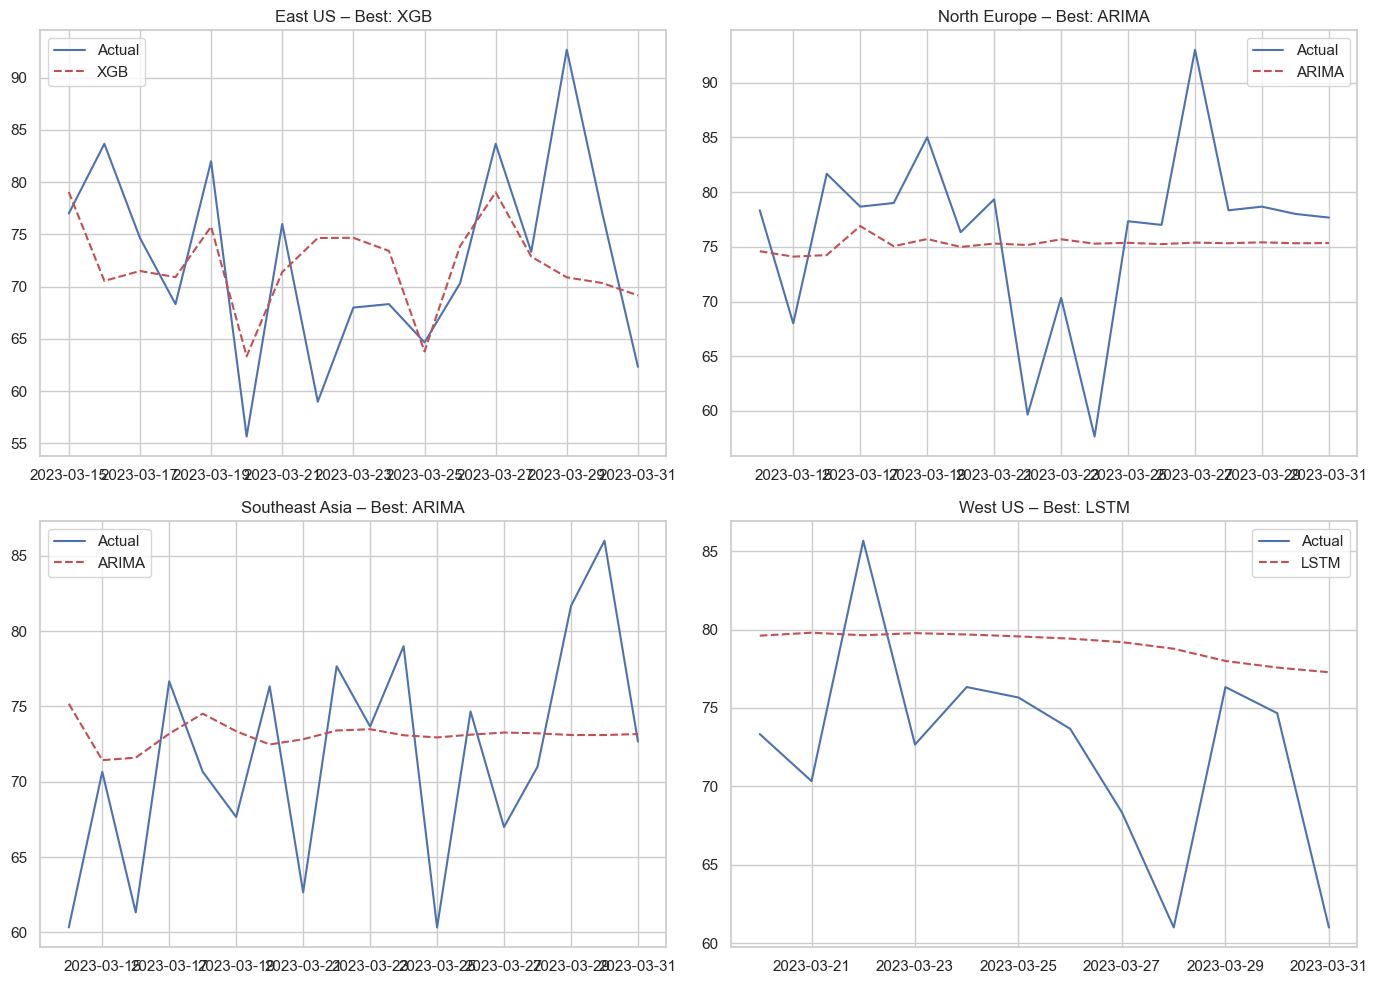


=== SUMMARY TABLE ===
                ARIMA_RMSE  ARIMA_MAE  ARIMA_MAPE  XGB_RMSE  XGB_MAE  \
region                                                                 
East US              10.20       8.19       11.00      8.50     6.57   
North Europe          8.02       6.04        8.34     10.59     7.74   
Southeast Asia        7.46       5.99        8.72      8.47     7.03   
West US              16.38      14.82       20.90      9.66     7.42   

                LSTM_RMSE  LSTM_MAE  LSTM_MAPE  
region                                          
East US             10.53      8.43        NaN  
North Europe        10.46      7.00        NaN  
Southeast Asia       8.58      7.43        NaN  
West US              9.06      7.61        NaN  


In [9]:
# Cell 9 (fixed): Compare & Visualize with Summary Table of Metrics
import matplotlib.pyplot as plt
import pandas as pd

# Prepare summary results list
results = []

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, region in zip(axes.flatten(), region_dfs):
    # Get metrics for the three models in the region
    metrics = {
        'ARIMA': arima_results[region][1],  # RMSE
        'XGB': xgb_results[region][1],      # RMSE
        'LSTM': lstm_results[region][2]     # RMSE
    }
    # Select best model based on RMSE
    best_model = min(metrics, key=metrics.get)
    
    # Plot according to best model
    if best_model == 'ARIMA':
        model, _, _, _ = arima_results[region]
        split = int(0.8 * len(region_dfs[region]))
        test = region_dfs[region]['usage_cpu'].iloc[split:]
        if region == 'East US':
            # For East US, reconstruct forecast similarly as in ARIMA cell
            ts = region_dfs[region]['usage_cpu']
            ts_diff = ts.diff().dropna()
            train_ts = ts_diff.iloc[: split - 1]
            test_ts  = ts_diff.iloc[split - 1 :]
            preds_diff = model.forecast(steps=len(test_ts))
            last_train = ts.iloc[split - 1]
            preds = np.r_[ [last_train], preds_diff ].cumsum()[1:]
        else:
            preds = model.forecast(steps=len(test))
        ax.plot(test.index, test, 'b-', label='Actual')
        ax.plot(test.index, preds, 'r--', label='ARIMA')
        
        # Get remaining metrics for the summary
        arima_rmse, arima_mae, arima_mape = arima_results[region][1:4]
        xgb_rmse, xgb_mae = xgb_results[region][1:3]
        lstm_rmse, lstm_mae, lstm_mape = lstm_results[region][2:5]
    
    elif best_model == 'XGB':
        _, xgb_rmse, xgb_mae, idx, y_test, preds = xgb_results[region]
        ax.plot(idx, y_test, 'b-', label='Actual')
        ax.plot(idx, preds, 'r--', label='XGB')
        
        # Get remaining metrics for summary
        arima_rmse, arima_mae, arima_mape = arima_results[region][1:4]
        lstm_rmse, lstm_mae, lstm_mape = lstm_results[region][2:5]
    
    else:  # best_model == 'LSTM'
        _, _, lstm_rmse, lstm_mae, X_test, y_test, preds = lstm_results[region]
        dates = region_dfs[region].index[-len(y_test):]
        ax.plot(dates, y_test, 'b-', label='Actual')
        ax.plot(dates, preds, 'r--', label='LSTM')
        
        # Get remaining metrics for summary
        arima_rmse, arima_mae, arima_mape = arima_results[region][1:4]
        xgb_rmse, xgb_mae = xgb_results[region][1:3]

        # get missing lstm mape if any
        lstm_mape = lstm_results[region][6] if len(lstm_results[region]) > 6 else np.nan

    ax.set_title(f"{region} – Best: {best_model}")
    ax.legend()
    
    # Append summary metrics for this region
    results.append({
        'region': region,
        'ARIMA_RMSE': round(arima_rmse, 2),
        'ARIMA_MAE': round(arima_mae, 2),
        'ARIMA_MAPE': round(arima_mape, 2),
        'XGB_RMSE': round(xgb_rmse, 2),
        'XGB_MAE': round(xgb_mae, 2),
        'LSTM_RMSE': round(lstm_rmse, 2),
        'LSTM_MAE': round(lstm_mae, 2),
        'LSTM_MAPE': round(lstm_mape, 2) if isinstance(lstm_mape, (float, int)) else np.nan
    })

plt.tight_layout()
plt.show()

# Create summary DataFrame and print
results_df = pd.DataFrame(results).set_index('region')
print("\n=== SUMMARY TABLE ===")
print(results_df)
